# NEURAL STYLE TRANSFER
NST allows to take an image and reproduce it with a new artistic style. The algorithm takes three images, an input image, a content-image, and a style-image, and changes the input to resemble the content of the content-image and the artistic style of the style-image.

**Underlying Principle:**
It define two distances, one for the content (Dc) and one for the style (Ds).
Dc measures how different the content is between two images while Ds measures how different the style is between two images. Then, we take a third image, the input, and transform it to minimize both its content-distance with the content-image and its style-distance with the style-image

**Reference Material:**
https://pytorch.org/tutorials/advanced/neural_style_tutorial.html


In [1]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch

# check the allocation machine
isCuda = torch.cuda.is_available()
machine = torch.cuda.get_device_properties(0) if isCuda else 'cpu'
print("Assigned Machine: ", machine)
device = torch.device('cuda:0' if isCuda else 'cpu')
print(f"cuda avaiable: {isCuda}, Device: {device}")

Assigned Machine:  _CudaDeviceProperties(name='Tesla V100-SXM2-16GB', major=7, minor=0, total_memory=16130MB, multi_processor_count=80)
cuda avaiable: True, Device: cuda:0


In [3]:
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA4_Phase2/session8-NST/notebooks/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA4_Phase2/session8-NST/notebooks


In [4]:
# Import standard packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import copy

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
from pathlib import Path

# important folders used in this application

Path(f'logs').mkdir(exist_ok=True)

SOLUTION_LOG_DIR = f"logs/logs_nst"     # root directoy for all the log of this notebook
Path(f'./{SOLUTION_LOG_DIR}').mkdir(exist_ok=True)

SAVED_MODELS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_models') # location to save models
SAVED_MODELS_DIR.mkdir(exist_ok=True)

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_results')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

PLOT_DIR = Path(f'./{SOLUTION_LOG_DIR}/doc_images')
PLOT_DIR.mkdir(exist_ok=True)

TEST_IMG_DIR = Path('/content/gdrive/My Drive/TSAI/EVA4_Phase2/session8-NST/notebooks/test_images')

In [6]:
# Application specific configurations
config_params = dict(
    seed=1,
    num_steps=1000,
    img_size=512 
)

torch.manual_seed(config_params['seed'])
if isCuda:
   torch.cuda.manual_seed(config_params['seed'])

## Loading the images

In [7]:
# desired size of the output image
imsize = config_params['img_size']

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])     # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader(f'{TEST_IMG_DIR}/style1.jpg')
content_img = image_loader(f'{TEST_IMG_DIR}/content1.jpg')

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

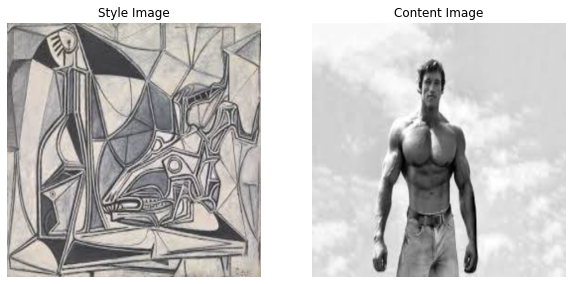

In [8]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

def tensor2img(tensor):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    return image

fig = plt.figure(figsize=(10,5))
cnt=1
ax = fig.add_subplot(1,2, cnt, xticks=[], yticks=[])
ax.axis('off')
ax.set_title("Style Image")
plt.imshow(tensor2img(style_img))

cnt += 1
ax = fig.add_subplot(1,2, cnt, xticks=[], yticks=[])
ax.axis('off')
ax.set_title('Content Image')
plt.imshow(tensor2img(content_img))

fig.savefig(f'{PLOT_DIR}/input.jpg')

## Loss Functions

In [9]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Importing Pre-Trained Model

In [10]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

**NOTE:** VGG networks are trained on images with each channel normalized by mean=0.485, 0.456, 0.406 and std=0.229, 0.224, 0.225

In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [12]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [13]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

In [14]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [15]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f'run {run}: Style Loss : {style_score.item():4f} Content Loss: {content_score.item():4f}')

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)
    return input_img

In [16]:
num_steps = config_params['num_steps']
print(f'Num of steps: {num_steps}')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=num_steps)

Num of steps: 1000
Building the style transfer model..
Optimizing..
run [50]: Style Loss : 135.625778 Content Loss: 11.002409
run [100]: Style Loss : 22.315178 Content Loss: 12.659559
run [150]: Style Loss : 4.077413 Content Loss: 12.742290
run [200]: Style Loss : 1.959315 Content Loss: 11.977280
run [250]: Style Loss : 1.647297 Content Loss: 11.159056
run [300]: Style Loss : 1.224587 Content Loss: 10.679531
run [350]: Style Loss : 1.079715 Content Loss: 10.287210
run [400]: Style Loss : 1.027334 Content Loss: 9.983158
run [450]: Style Loss : 0.869229 Content Loss: 9.814564
run [500]: Style Loss : 0.780865 Content Loss: 9.634274
run [550]: Style Loss : 0.704328 Content Loss: 9.481777
run [600]: Style Loss : 0.647189 Content Loss: 9.363411
run [650]: Style Loss : 0.599376 Content Loss: 9.270790
run [700]: Style Loss : 0.562973 Content Loss: 9.193037
run [750]: Style Loss : 0.534945 Content Loss: 9.127560
run [800]: Style Loss : 0.513680 Content Loss: 9.070465
run [850]: Style Loss : 0.4

In [17]:
def show_result(s_img, c_img, o_img, save_filename=None):
    fig = plt.figure(figsize=(15,5))

    cnt=1
    ax = fig.add_subplot(1,3, cnt, xticks=[], yticks=[])
    ax.axis('off')
    ax.set_title("Style Image")
    plt.imshow(s_img)
    
    cnt += 1
    ax = fig.add_subplot(1,3, cnt, xticks=[], yticks=[])
    ax.axis('off')
    ax.set_title('Content Image')
    plt.imshow(c_img)

    cnt += 1
    ax = fig.add_subplot(1,3, cnt, xticks=[], yticks=[])
    ax.axis('off')
    ax.set_title('Output Image')
    plt.imshow(o_img)

    if save_filename:
      fig.savefig(save_filename)

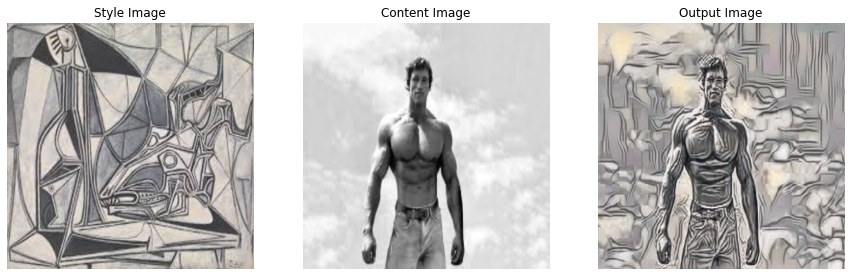

In [18]:
s_img = tensor2img(style_img)
c_img = tensor2img(content_img)
o_img = tensor2img(output)
show_result(s_img, c_img, o_img, save_filename=f'{PLOT_DIR}/result.jpg')